In [1]:
import sys
sys.path.append("../")
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from mfmodeling import SingleGP, NARGP
from time import time as timer
import pickle

2025-09-25 10:07:39.247985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/maeyama/mylib/Miniforge3/envs/subB_3.12.11/lib/python3.12/site-packages/gpflow/versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Preparation of data set

In [2]:
np.random.seed(15)
tf.random.set_seed(15)

def high(x):
    '''
    High-fidelity function
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    r = np.sqrt(x1**2+x2**2)
    return sp.special.j0(r)

def low(x):
    '''
    Low-fidelity function
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    r = np.sqrt(x1**2+x2**2)
    return (1-r**2/4)/(1+r**4)+np.sqrt(2/(np.pi*np.abs(r)))*r**4/(1+r**4)

def scale_range(x,ub,lb):
    Np = x.shape[0]
    dim = x.shape[1]
    for i in range(0,Np):
        for j in range(0,dim):
            tmp = ub[j] -lb[j]
            x[i][j] = tmp*x[i][j] + lb[j]
    return x

def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))


# nlow = 400
# w0 = -10 + 20*np.random.rand(nlow)
# w1 = -10 + 20*np.random.rand(nlow)
# # w0 = 5*np.random.normal(size=nlow)
# # w1 = 5*np.random.normal(size=nlow)
# data_low_x = np.stack([w0,w1],axis=-1)
from scipy.stats import qmc
pow2=9
sampler = qmc.Sobol(d=2, seed=np.random.default_rng(15))
data_low_x = np.array((-8,-8)) + sampler.random_base2(m=pow2)*np.array((16,16))
nlow=2**pow2
data_low_y = low(data_low_x)
print(data_low_x.shape)

data_restrict = data_low_x[data_low_x[:,0]<1e-8]
data_restrict = data_restrict[-7<data_restrict[:,0]]
data_restrict = data_restrict[data_restrict[:,1]<7]
data_restrict = data_restrict[-7<data_restrict[:,1]]
print(data_restrict.shape)
nhigh = data_restrict.shape[0]
if data_restrict.shape[0] < nhigh:
    print("Data points in the restricted region is too small")
else:
    perm = np.random.permutation(data_restrict.shape[0])
    data_high_x = data_restrict[perm[0:nhigh],:]
print(data_high_x.shape)

df = pd.DataFrame({"x0":data_low_x[:,0],"x1":data_low_x[:,1],"y_low":low(data_low_x)})
df.to_csv("low_fidelity_data.csv",index=False)
df = pd.DataFrame({"x0":data_high_x[:,0],"x1":data_high_x[:,1],"y_high":high(data_high_x)})
df.to_csv("high_fidelity_data.csv",index=False)

(512, 2)
(196, 2)
(196, 2)


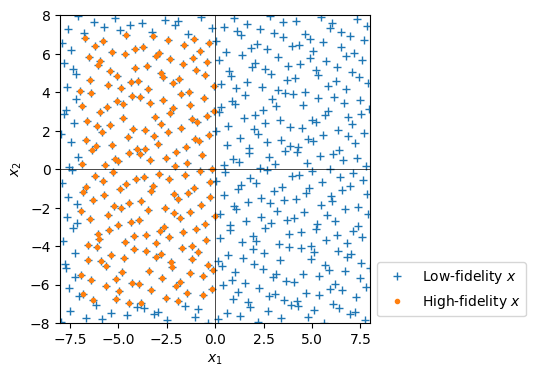

In [3]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.plot(data_low_x[:,0],data_low_x[:,1],"+",label=r"Low-fidelity $x$")
ax.plot(data_high_x[:,0],data_high_x[:,1],".",label=r"High-fidelity $x$")
ax.axhline(0,lw=0.5,c="k")
ax.axvline(0,lw=0.5,c="k")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.legend(loc="lower left", bbox_to_anchor=(1,0))
plt.show()

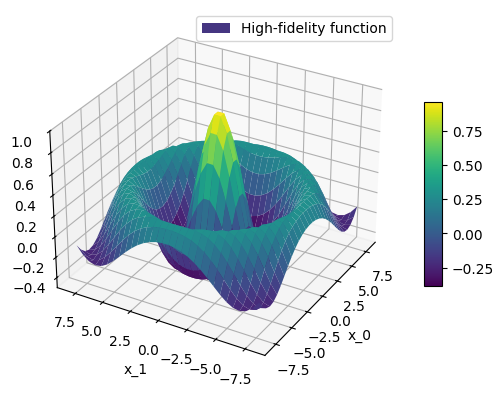

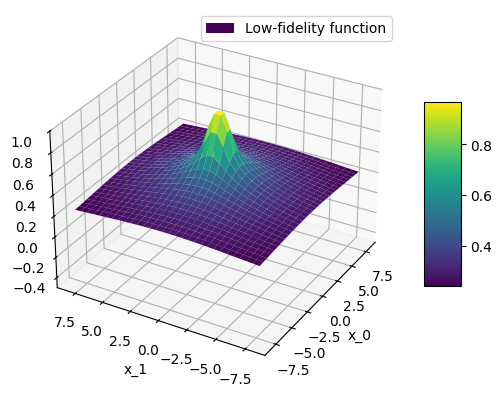

In [4]:
# 推定に用いる入力データ: Low, medium, high-fidelity dataset
data_low_y = low(data_low_x)
data_high_y = high(data_high_x)

# データセットの描画
%matplotlib inline
# %matplotlib qt
x0 = np.linspace(-8,8,30)
x1 = np.linspace(-8,8,30)
x0m, x1m = np.meshgrid(x0,x1)
xm = np.stack([x0m,x1m],axis=-1)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.plot_wireframe(x0m,x1m,high(xm),lw=0.5,color="black",label="High-fidelity function")
surf = ax.plot_surface(x0m,x1m,high(xm),cmap="viridis",label="High-fidelity function")
fig.colorbar(surf, shrink=0.5, aspect=10)
# ax.plot(data_high_x[:,0],data_high_x[:,1],data_high_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-0.5,1)
ax.view_init(30,-150)
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.plot_wireframe(x0m,x1m,low(xm),lw=0.5,color="black",label="Low-fidelity function")
surf = ax.plot_surface(x0m,x1m,low(xm),cmap="viridis",label="Low-fidelity function")
fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.plot(data_low_x[:,0],data_low_x[:,1],data_low_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-0.5,1)
ax.view_init(30,-150)
ax.legend()
plt.show()

### Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP)

In [5]:
# # Set kernel name to use
# # KERNEL_NAME = "RBF"
# # KERNEL_NAME = "SpectralMixture"
# KERNEL_NAME = "NeuralKernelNetwork"

# data_list = [[data_low_x,data_low_y[:,None]],
#              [data_high_x,data_high_y[:,None]]]
# single_gp_config_list = [
#     {"kernel": KERNEL_NAME},
#     {"kernel": KERNEL_NAME},
# ]

# # Uncomment the following to use different kernel for different fidelity data.
# # However, if GPy implementation are being used,
# # Spectral Mixture Kernel and Neural Kernel Network are not implemented,
# # so RBF will be used.

# # Different kernel for each fidelity
# #single_gp_config_list = [
# #    {"kernel": "RBF"},
# #    {"kernel": "SpectralMixture"},
# #    {"kernel": "NeuralKernelNetwork"},
# #]

# # Different initialization for each fidelity
# #single_gp_config_list = [
# #    {"kernel": "RBF", "kernel_args": {"lengthscales": [1.0, 1.0]}},
# #    {"kernel": "RBF", "kernel_args": {"lengthscales": [2.0, 2.0]}},
# #    {"kernel": "RBF", "kernel_args": {"lengthscales": [3.0, 3.0]}},
# #]

# model_nargp = NARGP(
#     data_list = data_list,
#     single_gp_config_list=single_gp_config_list,
#     normalize=True)
# from time import time as timer
# t1=timer()
# model_nargp.optimize(optimize_restarts=10, nMonteCarlo=1000, verbose=False)
# t2=timer(); print(t2-t1, xm.size)


# if KERNEL_NAME == "RBF":
#     with open("model_NARGP_RBF.pkl","wb") as f:
#         pickle.dump(model_nargp,f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_NARGP_SMK.pkl","wb") as f:
#         pickle.dump(model_nargp,f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_NARGP_NKN.pkl","wb") as f:
#         pickle.dump(model_nargp,f)


# # if KERNEL_NAME == "RBF":
# #     with open("model_NARGP_RBF.pkl","rb") as f:
# #         model_nargp = pickle.load(f)
# # elif KERNEL_NAME == "SpectralMixture":
# #     with open("model_NARGP_SMK.pkl","rb") as f:
# #         model_nargp = pickle.load(f)
# # elif KERNEL_NAME == "NeuralKernelNetwork":
# #     with open("model_NARGP_NKN.pkl","rb") as f:
# #         model_nargp = pickle.load(f)



# t1=timer()
# mean, var = model_nargp.predict(xm.reshape(xm.size//2,2),nMonteCarlo=100)
# t2=timer(); print(t2-t1, xm.size)

### Single GP using only high-fidelity data (for comparison)

In [6]:
# Set kernel name to use
# KERNEL_NAME = "RBF"
# KERNEL_NAME = "SpectralMixture"
KERNEL_NAME = "NeuralKernelNetwork"

data = [data_high_x,data_high_y[:,None]]
model_singlegp = SingleGP(data = data, kernel=KERNEL_NAME, normalize=True)
model_singlegp.optimize(optimize_restarts=10, verbose=False)


if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","wb") as f:
        pickle.dump(model_singlegp,f)


# if KERNEL_NAME == "RBF":
#     with open("model_singleGP_RBF.pkl","rb") as f:
#         model_singlegp = pickle.load(f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_singleGP_SMK.pkl","rb") as f:
#         model_singlegp = pickle.load(f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_singleGP_NKN.pkl","rb") as f:
#         model_singlegp = pickle.load(f)


mean_singlegp, var_singlegp = model_singlegp.predict(xm.reshape(xm.size//2,2))

2025-09-25 10:07:48.530628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 129516 MB memory:  -> device: 0, name: AMD Instinct MI300A, pci bus id: 0002:02:00.0
2025-09-25 10:08:09.462142: I tensorflow/core/util/rocm_solvers.cc:125] Creating GpuSolver handles for stream 0x55c9972c8960
2025-09-25 10:08:15.693351: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-25 10:08:15.734861: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-25 10:08:15.744045: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output wit

NameError: name 'mean' is not defined

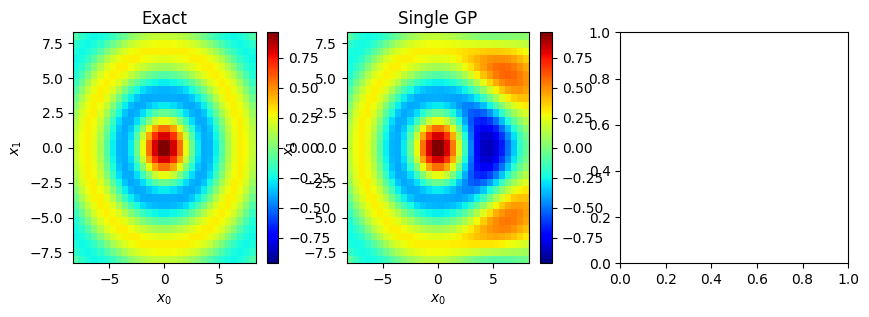

In [7]:
vmax = high(xm).max()
vmin = high(xm).min()
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
quad = ax.pcolormesh(x0m,x1m,high(xm),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("Exact")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(132)
quad = ax.pcolormesh(x0m,x1m,mean_singlegp.reshape(x0m.shape),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("Single GP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(133)
quad = ax.pcolormesh(x0m,x1m,mean.reshape(x0m.shape),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("NARGP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

In [ ]:
error_singlegp = mean_singlegp.reshape(x0m.shape)-high(xm)
error_nargp = mean.reshape(x0m.shape)-high(xm)
emax = max([error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min()])
print(error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min(),emax)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
quad = ax.pcolormesh(x0m,x1m,error_singlegp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (Single GP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(122)
quad = ax.pcolormesh(x0m,x1m,error_nargp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (NARGP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

In [ ]:
nsample = 1000
w0 = -5 + 15*np.random.rand(nsample)
w1 = 15 * np.random.rand(nsample)
xsample = np.stack([w0,w1],axis=-1)

t1=timer()
mean0, var0 = model_nargp.predict(xsample,ifidelity=0,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()
mean1, var1 = model_nargp.predict(xsample,ifidelity=1,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(low(xsample),high(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean0,mean1,".",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("High-fidelity function")
ax.legend()
fig.tight_layout()
ax.legend()
plt.show()

In [ ]:
mean_singlegp, var_singlegp = model_singlegp.predict(xsample)
exact_high = high(xsample)[:,None]
print(exact_high.shape,mean_singlegp.shape)
R2_singlegp = float(1.0 - sum((exact_high-mean_singlegp)**2)/sum((exact_high-exact_high.mean())**2))
R2_nargp = float(1.0 - sum((exact_high-mean1)**2)/sum((exact_high-exact_high.mean())**2))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
vmin = -2
vmax = 2
ax.plot(np.linspace(vmin,vmax,2),np.linspace(vmin,vmax,2),c="k",lw=0.5)
ax.plot(mean_singlegp,exact_high,".",c="tab:green",label="Single GP ($R^2=${:.5f})".format(R2_singlegp))
ax.plot(mean1,exact_high,".",c="b",label="NARGP ($R^2=${:.5f})".format(R2_nargp))
ax.set_xlabel("Posterior mean")
ax.set_ylabel("Exact solution")
ax.set_xlim(vmin,vmax)
ax.set_ylim(vmin,vmax)
ax.legend()
plt.show()
